### Plot the confusion matrix after obtaining the predictions for first CHIME/FRB catalog with classification with set of binary classifiers and multi-class classifier

In [ ]:
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import keras

2026-01-24 01:51:57.359996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-24 01:51:57.726790: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-24 01:51:57.815027: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akumar/simpulse:
2026-01-24 01:51:57.815072: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ign

In [ ]:
# function to  Load CHIME FRB images (interpolated examples) and correct labels .
def read_chime_data(data_file, label_file):
    """
    Reads interpolated CHIME FRB dynamic spectra and label file,
    normalizes images and returns per-class train/test splits.

    Parameters
    ----------
    data_file : str
        Path to the NumPy `.npz` file containing FRB images (arr_0).
    label_file : str
        Path to a text file containing morphology labels (one per line: A, B, C, C1, or C2).

    Returns
    -------
    labels_train, images_train, labels_test, images_test
    """

    # Containers for each morphology class
    frbdn1, frbdn2, frbdn3, frbdn4, frbdn5 = [], [], [], [], []
    frbdl1, frbdl2, frbdl3, frbdl4, frbdl5 = [], [], [], [], []

    # ---- Load data ----
    with np.load(data_file) as frbdata:
        frbd = frbdata["arr_0"]

    with open(label_file) as f:
        correct_type = f.readlines()

    # ---- Assign images and labels ----
    for i in range(len(correct_type)):
        immax = frbd[i].max()
        norm_img = frbd[i] / (immax / 255)

        if correct_type[i] == "A\n":
            frbdn1.append(norm_img)
            frbdl1.append([1., 0., 0., 0., 0.])

        if correct_type[i] == "B\n":
            frbdn2.append(norm_img)
            frbdl2.append([0., 1., 0., 0., 0.])

        if correct_type[i] == "C\n":
            frbdn3.append(norm_img)
            frbdl3.append([0., 0., 1., 0., 0.])

        if correct_type[i] == "C1\n":
            frbdn4.append(norm_img)
            frbdl4.append([0., 0., 0., 1., 0.])

        if correct_type[i] == "C2\n":
            frbdn5.append(norm_img)
            frbdl5.append([0., 0., 0., 0., 1.])

    # ---- Train / test split (per class) ----
    lenA  = int(len(frbdn1) / 2)
    lenB  = int(len(frbdn2) / 2)
    lenC  = int(len(frbdn3) / 2)
    lenC1 = int(len(frbdn4) / 2)
    lenC2 = int(len(frbdn5) / 2)

    # Concatenate per-class train/test splits into flat lists expected by downstream code
    images_train = (
        frbdn1[:lenA] +
        frbdn2[:lenB] +
        frbdn3[:lenC] +
        frbdn4[:lenC1] +
        frbdn5[:lenC2]
    )

    labels_train = (
        frbdl1[:lenA] +
        frbdl2[:lenB] +
        frbdl3[:lenC] +
        frbdl4[:lenC1] +
        frbdl5[:lenC2]
    )

    images_test = (
        frbdn1[lenA:] +
        frbdn2[lenB:] +
        frbdn3[lenC:] +
        frbdn4[lenC1:] +
        frbdn5[lenC2:]
    )

    labels_test = (
        frbdl1[lenA:] +
        frbdl2[lenB:] +
        frbdl3[lenC:] +
        frbdl4[lenC1:] +
        frbdl5[lenC2:]
    )

    return labels_train, images_train,  labels_test, images_test


In [ ]:
# function to plot confusion matrix with percentage and raw count annotations
def plot_confusion_matrix(
    confusion_matrix,
    class_names,
    normalize=True,
    cmap="Blues",
    fontsize=12
):
    """
    Plot a confusion matrix with percentage and raw count annotations.

    Parameters
    ----------
    confusion_matrix : np.ndarray
        Square confusion matrix of shape (N, N).
    class_names : list of str
        Class labels (length N).
    normalize : bool, optional
        If True, row-normalize and show percentages. Default is True.
    cmap : str, optional
        Colormap for heatmap. Default is "Blues".
    fontsize : int, optional
        Font size for annotations. Default is 12.
    """

    confusion_matrix = np.asarray(confusion_matrix)
    n_classes = len(class_names)

    if normalize:
        cm_percent = (
            confusion_matrix
            / confusion_matrix.sum(axis=1, keepdims=True)
            * 100
        )
    else:
        cm_percent = confusion_matrix.copy()

    fig, ax = plt.subplots()

    heatmap = sns.heatmap(
        cm_percent,
        annot=False,
        cmap=cmap,
        xticklabels=class_names,
        yticklabels=class_names,
        linecolor="black",
        linewidths=0.5,
        cbar=False,
        ax=ax
    )

    # Add annotations: percentage + raw count
    for i in range(n_classes):
        for j in range(n_classes):
            if normalize:
                text = f"{cm_percent[i, j]:.1f}%\n{confusion_matrix[i, j]}"
            else:
                text = f"{confusion_matrix[i, j]}"

            cell_color = heatmap.collections[0].get_facecolors()[
                i * n_classes + j
            ]
            r, g, b, _ = cell_color
            brightness = 0.299 * r + 0.587 * g + 0.114 * b
            text_color = "white" if brightness < 0.65 else "black"

            ax.text(
                j + 0.5,
                i + 0.5,
                text,
                ha="center",
                va="center",
                fontsize=fontsize,
                color=text_color
            )

    ax.set_xlabel("Predicted Class", fontsize=fontsize)
    ax.set_ylabel("True Class", fontsize=fontsize)

    ax.tick_params(axis="x", labelsize=fontsize)
    ax.tick_params(axis="y", labelsize=fontsize)

    plt.tight_layout()
    plt.show()


In [ ]:
# Locate and read the combined scores CSV produced by the inference pipeline
# This file should contain columns with per-class scores and the true labels
filename = glob.glob('all_scores.csv')
data = pd.read_csv(filename[0])
# Inspect a bit to verify we've loaded the expected file
print('Loaded', filename[0], 'with shape', data.shape)

In [ ]:
# Identify score columns (columns produced by binary classifiers end with '_score')
score_columns = [col for col in data.columns if '_score' in col]
# Derive the predicted type by finding the column with the highest score per row
# and extracting the roman numeral class label (I/II/III/IV/V) from the column name
data['pred_type'] = data[score_columns].idxmax(axis=1).str.extract(r'([IV]+)')
print('Using score columns:', score_columns)

In [ ]:
# Calculate the confusion matrix for the 5-class problem (I-V).
# We build a zero matrix and increment the cell corresponding to (true, pred) for each row.
confusion_matrix = np.zeros((5, 5), dtype=int)
# Mapping from roman-numeral class labels to matrix indices
type_mapping = {'I': 0, 'II': 1, 'III': 2, 'IV': 3, 'V': 4}

# Iterate over the loaded results and populate the confusion matrix
for _, row in data.iterrows():
    actual_type = row['actual_type']  # ground-truth label (I, II, ...)
    pred_type = row['pred_type']      # predicted label derived from scores

    # Only count rows where both labels are recognized in the mapping
    if actual_type in type_mapping and pred_type in type_mapping:
        actual_index = type_mapping[actual_type]
        pred_index = type_mapping[pred_type]
        confusion_matrix[actual_index][pred_index] += 1

# The confusion_matrix now contains raw counts for each (true,pred) pair

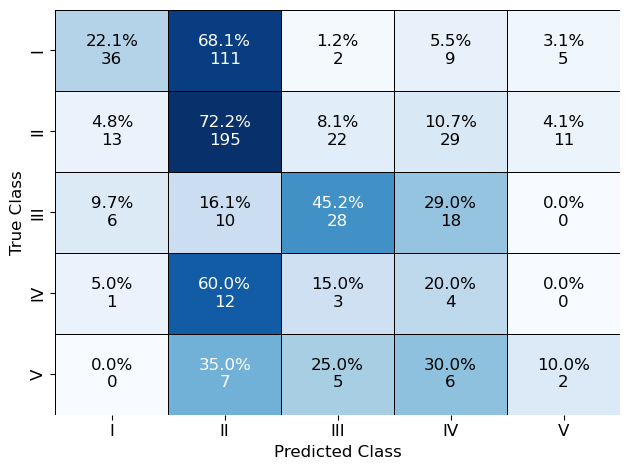

In [ ]:
# Plot the 5x5 confusion matrix using the helper which shows percentages and raw counts
plot_confusion_matrix(confusion_matrix, ['I', 'II', 'III', 'IV', 'V'])

In [ ]:
# Read the predictions CSV produced for CHIME bursts (this file contains per-burst predictions)
csv_path = "predictions_for_chime_bursts.csv"

# Read the CSV into a DataFrame
df = pd.read_csv(csv_path)

# Quick sanity checks to confirm expected columns and number of rows
print("Columns:", list(df.columns))
print("Number of rows:", len(df))

# Show the first few rows to inspect the format (predicted columns, true labels etc.)
df.head()

Columns: ['correct_type', 'predict_type', 'pred_type_w_A', 'pred_type_w_B', 'pred_type_w_AB']
Number of rows: 535


,correct_type,predict_type,pred_type_w_A,pred_type_w_B,pred_type_w_AB
0,B,B,B,A,C1
1,B,B,B,A,C1
2,B,B,B,C1,C1
3,B,B,B,A,C1
4,A,B,B,A,C1


In [ ]:
# Calculate the confusion matrix excluding Type I
#Here B corresponds to type II, C to type III, C1 to type IV and C2 to type V

confusion_matrix = np.zeros((4,4) , dtype=int)
type_mapping = { 'B': 0 , 'C': 1 , 'C1': 2, 'C2': 3 }

for _, row in df.iterrows():
    actual_type = row['correct_type']
    pred_type = row['pred_type_w_A']

    if actual_type in type_mapping and pred_type in type_mapping:
        actual_index = type_mapping[actual_type]
        pred_index = type_mapping[pred_type]
        confusion_matrix[actual_index][pred_index] += 1 


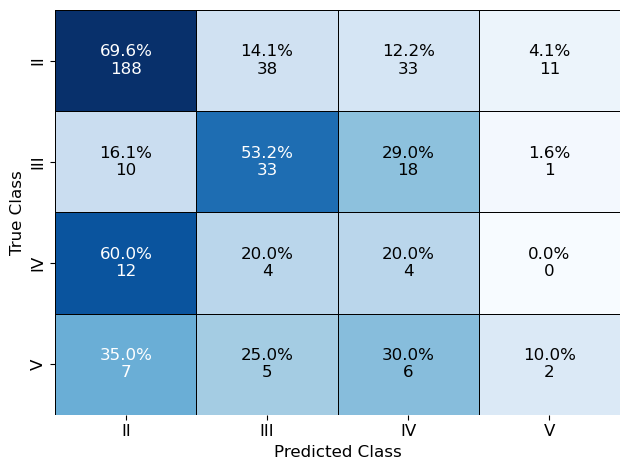

In [13]:
plot_confusion_matrix(confusion_matrix,  ['II' , "III", "IV", "V"])

In [14]:
# Calculate the confusion matrix excluding Type II
#Here A corresponds to type I, C to type III, C1 to type IV and C2 to type V

confusion_matrix = np.zeros((4,4) , dtype=int)
type_mapping = { 'A': 0 , 'C': 1 , 'C1': 2, 'C2': 3 }

for _, row in df.iterrows():
    actual_type = row['correct_type']
    pred_type = row['pred_type_w_B']

    if actual_type in type_mapping and pred_type in type_mapping:
        actual_index = type_mapping[actual_type]
        pred_index = type_mapping[pred_type]
        confusion_matrix[actual_index][pred_index] += 1 

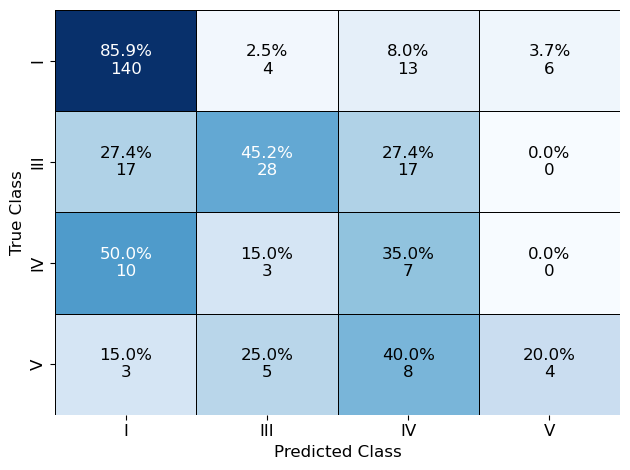

In [15]:
plot_confusion_matrix(confusion_matrix,  ['I' , "III", "IV", "V"])

In [16]:
# Calculate the confusion matrix excluding Type I and type II
#Here C corresponds to type III, C1 to type IV and C2 to type V

confusion_matrix = np.zeros((3,3) , dtype=int)
type_mapping = { 'C': 0 , 'C1': 1, 'C2': 2 }

for _, row in df.iterrows():
    actual_type = row['correct_type']
    pred_type = row['pred_type_w_AB']

    if actual_type in type_mapping and pred_type in type_mapping:
        actual_index = type_mapping[actual_type]
        pred_index = type_mapping[pred_type]
        confusion_matrix[actual_index][pred_index] += 1 

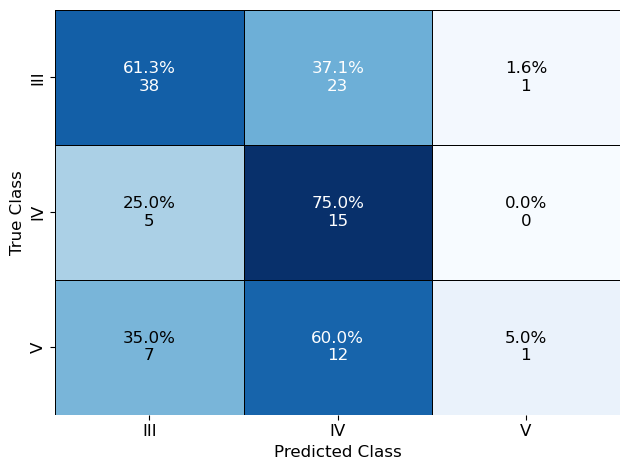

In [17]:
plot_confusion_matrix(confusion_matrix,  ['III', "IV", "V"])

In [2]:
### this model is provided in the models folder
single_multi = tf.keras.models.load_model('models/model_single_multi/')

2026-01-24 01:52:05.088052: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akumar/simpulse:
2026-01-24 01:52:05.088612: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2026-01-24 01:52:05.088658: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (precise): /proc/driver/nvidia/version does not exist
2026-01-24 01:52:05.089779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#loading the chime data and splitting into test and train

chime_labels, chime_data, chime_test_labels, chime_test_data = read_chime_data('files/chime_interp_frbs.npz','files/chime_labels.txt')
chime_test_data = np.asarray(chime_test_data)
chime_test_data.shape += 1,
chime_test_labels = np.asarray(chime_test_labels)

In [9]:
## testing with the chime data
predictions = single_multi.predict( chime_test_data ) 

predicted_classes = np.argmax(predictions , axis =1 )
test_labels = np.argmax( chime_test_labels, axis = 1 )

9/9 [==============================] - 1s 99ms/step


In [ ]:
# classification report for chime data for half fo the bursts in the first CHIME/FRB catalog
report= classification_report(test_labels, predicted_classes, target_names=['A' ,'B', 'C', 'C1', 'C2'] )
print(report)

              precision    recall  f1-score   support

           A       0.61      0.53      0.57        81
           B       0.68      0.62      0.65       135
           C       0.50      0.58      0.54        31
          C1       0.04      0.10      0.05        10
          C2       0.12      0.10      0.11        10

    accuracy                           0.55       267
   macro avg       0.39      0.39      0.38       267
weighted avg       0.59      0.55      0.57       267



<Figure size 1800x1800 with 0 Axes>

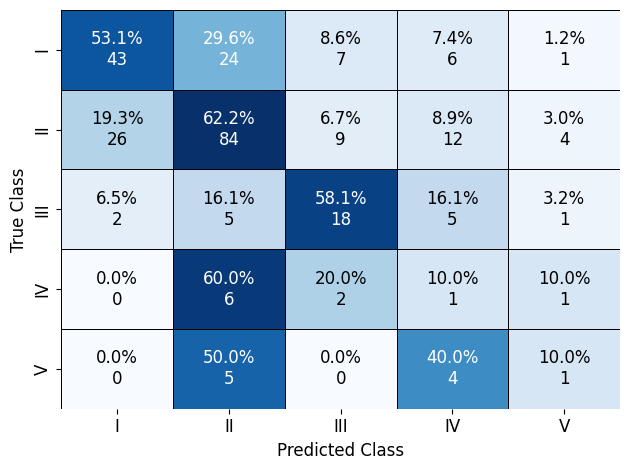

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)

# Normalize confusion matrix to percentage and plot
plot_confusion_matrix(conf_matrix,  ['I' , 'II' , "III", "IV", "V"])
